In [1]:
#import necessary libraries for regression analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('bmh')

from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import scipy.stats as stats
from sklearn.model_selection import train_test_split

import pylab
from modelCustomFunctions import create_ols, check_resid_distribution, check_features_vif, get_low_pval_features

In [2]:
df = pd.read_csv('Cleaned_Data_w_Outliers', index_col=0)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,renovated
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,1690,7639,0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,2720,8062,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,1360,5000,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,1800,7503,0


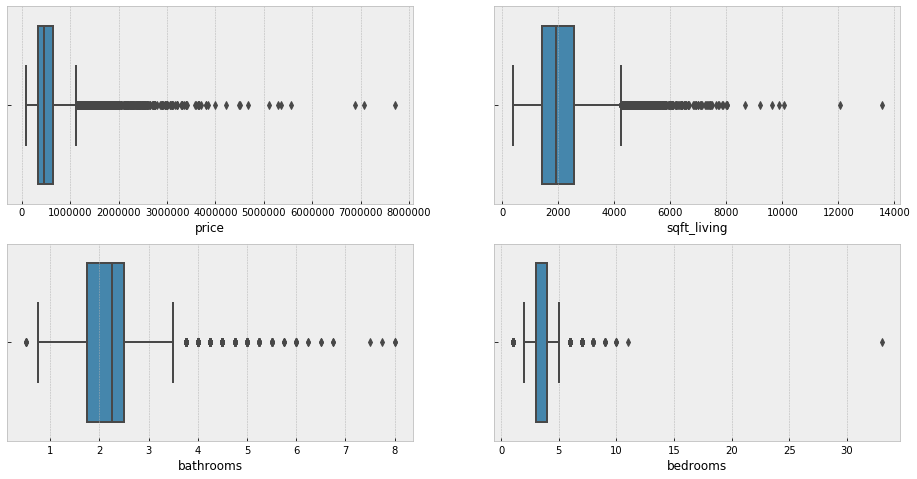

In [3]:
#Looking for Outliers
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.boxplot(x=df['price'])
plt.subplot(222)
sns.boxplot(x=df['sqft_living'])
plt.subplot(223)
sns.boxplot(x=df['bathrooms'])
plt.subplot(224)
sns.boxplot(x=df['bedrooms'])


In [4]:
#Remove outliers
df = df[df["price"] < 700000]
df = df[df["bedrooms"] < 10]
df = df[df["sqft_living"] < 10000]

In [5]:
#Also, drop the yr_renoavted column since we have a new feature called 'renovated'
df = df.drop(columns = 'yr_renovated')

In [6]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,renovated
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,98125,1690,7639,0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,2720,8062,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,98136,1360,5000,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,1800,7503,0


In [7]:
df.nunique() #looking at unique values in each column

price            2689
bedrooms            9
bathrooms          22
sqft_living       781
sqft_lot         8020
floors              6
waterfront          2
view                5
condition           5
grade               9
sqft_above        730
sqft_basement     236
yr_built          116
zipcode            69
sqft_living15     616
sqft_lot15       7104
renovated           3
dtype: int64

### Assumptions Check: Linearity and Multicolinearity

In [8]:
con_feats = ['sqft_living', 'sqft_lot','sqft_above','sqft_basement', 'sqft_living15', 'sqft_lot15']
cat_feats = ['bedrooms', 'bathrooms', 'floors','waterfront','view','condition','grade', 'yr_built', 'zipcode', 'renovated']

In [9]:
target = "price"
features = list(df.columns)
features.remove(target)

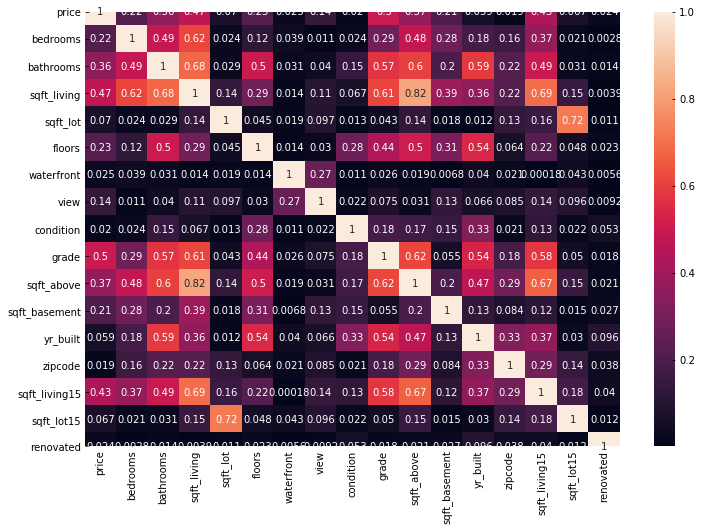

In [10]:
#explore features with high correlation 
corr = df.corr().abs()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True)
plt.show()

In [11]:
#Check Multicolinearity

check_features_vif(df, target)

,VIF Factor,features
0,26.6,bedrooms
1,27.7,bathrooms
2,875.0,sqft_living
3,2.4,sqft_lot
4,16.5,floors
5,1.1,waterfront
6,1.2,view
7,34.2,condition
8,155.7,grade
9,664.9,sqft_above


['sqft_living',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode',
 'sqft_living15']

In [12]:
df = df.drop(columns = ['sqft_above','sqft_basement','sqft_living15'])

In [13]:
check_features_vif(df, target)

,VIF Factor,features
0,26.5,bedrooms
1,26.7,bathrooms
2,26.0,sqft_living
3,2.4,sqft_lot
4,13.2,floors
5,1.1,waterfront
6,1.2,view
7,34.0,condition
8,146.9,grade
9,9747.9,yr_built


['condition', 'grade', 'yr_built', 'zipcode']

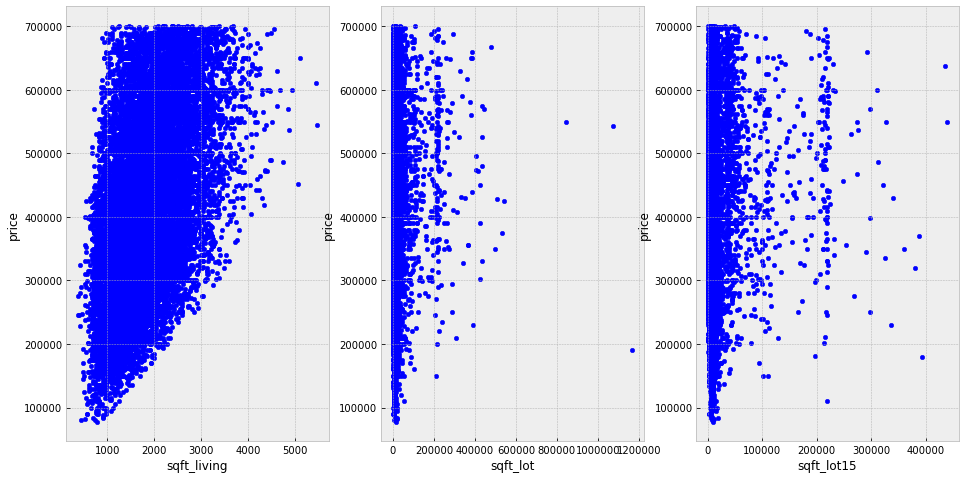

In [14]:
fig, axs = plt.subplots(1, 3,)
df.plot(kind='scatter', x='sqft_living', y='price', ax=axs[0], figsize=(16, 8))
df.plot(kind='scatter', x='sqft_lot', y='price', ax=axs[1])
df.plot(kind='scatter', x='sqft_lot15', y='price', ax=axs[2])

In [20]:
def check_homoskedasticity(model, df, target : "", features):
    
    """Input: 
    model: an sm.OLS model  
    df: a data frame
    target : a string 
    features: the features of the model 
    
    Retrun: 
    True if 
    False  
    Prints out P-value and F-statistic
    ------------------------
    Uses the Breusch–Pagan test. If p-value is below 0.05, then 
    the null hypothesis of homoskedasticity is rejected and 
    heteroskedasticity is assumed.
    """ 
    
    #Plot scatter plot
    y_hat = df[target] - model.predict(df[features])
            
    plt.scatter(model.predict(df[features]), y_hat, alpha = 0.2)
    plt.plot(model.predict(df[features]), [0 for i in range(len(df))])
    plt.show()

    #run Pegan test
    _, pval, _, f_pval = diag.het_breuschpagan(model.resid, model.model.exog)
    
    print('-'*50)
    print('The P-value is: {:.2}'.format(pval))
    print('The F-statistic is {:.2}'.format(f_pval))
    print('-'*50)
    
    if pval >= 0.05:
    
        print("The p-value is above 0.05, thus we fail to reject the null hypothesis of homoskedasticity")
        return True

    return False

### Baseline Model

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
baseline = create_ols(df, target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     847.1
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:12:46   Log-Likelihood:            -2.2137e+05
No. Observations:               17021   AIC:                         4.428e+05
Df Residuals:                   17007   BIC:                         4.429e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.387e+07   1.69e+06     -8.208      

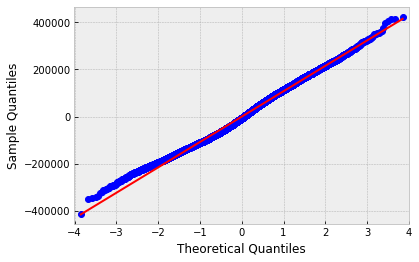

The mean of the residuals is: 6.7e-07. The closer to 0, the better.


In [17]:
check_resid_distribution(baseline)

In [18]:
features = list(df.columns)
features.remove(target)

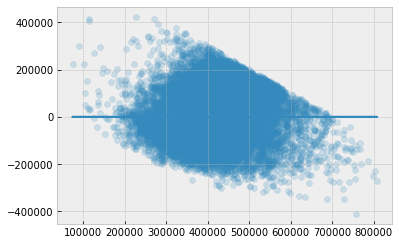

--------------------------------------------------
The P-value is: 2.2e-73
The F-statistic is 3e-74
--------------------------------------------------


False

In [21]:
check_homoskedasticity(baseline,df,target,features)

### Model 2

In [22]:
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'yr_built',
 'zipcode',
 'sqft_lot15',
 'renovated']

Continuous columns: 'sqft_living', 'sqft_lot', 'price'

(0, 10000)

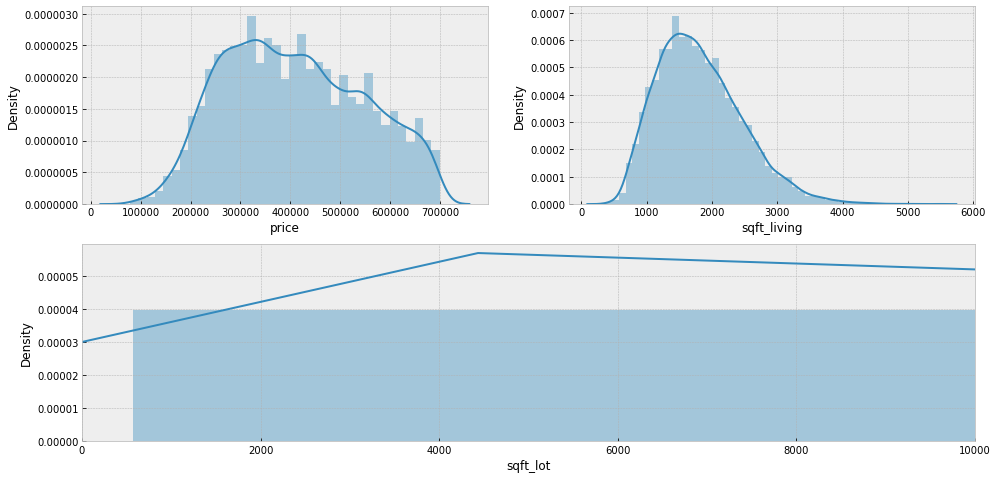

In [23]:
#Exploring distributions of continuous variables
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.distplot(df.price, label='Prices')
plt.subplot(222)
sns.distplot(df.sqft_living, label='Sqft Living')
plt.subplot(212)
sns.distplot(df.sqft_lot, label='Sqft Lot')
plt.xlim(0, 10000)

In [24]:
# Convert to logs
price = np.log(df.price)
sqft_living = np.log(df.sqft_living)
sqft_lot = np.log(df.sqft_lot)

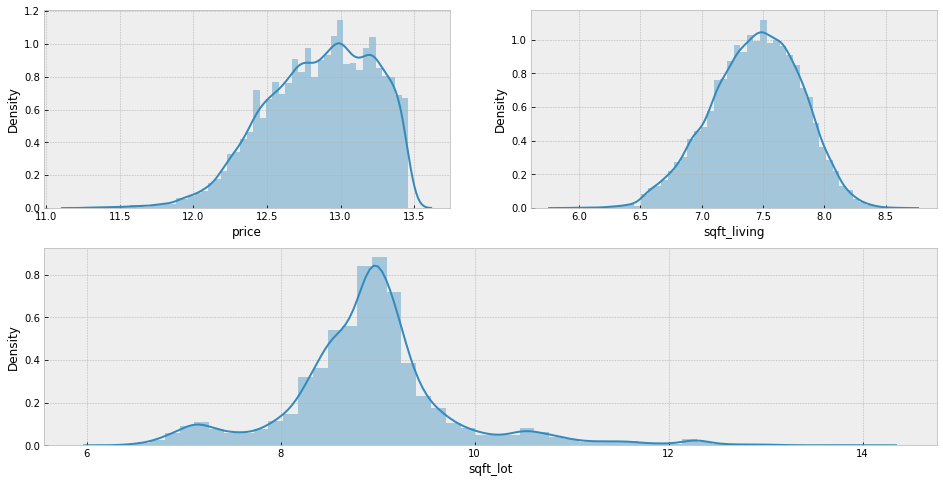

In [25]:
#Comparing the distributions
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.distplot(price, label='Prices')
plt.subplot(222)
sns.distplot(sqft_living, label='Sqft Living')
plt.subplot(212)
sns.distplot(sqft_lot, label='Sqft Lot')

In [26]:
#Next, do min-max transformation:

#df['price'] = ( price - min(price) ) / ( max(price) - min(price) )
#df['sqft_living'] = ( sqft_living - min(sqft_living) ) / ( max(sqft_living) - min(sqft_living) )
#df['sqft_lot'] = ( sqft_lot - min(sqft_lot) ) / ( max(sqft_lot) - min(sqft_lot) )

df['sqft_living'] = sqft_living
df['sqft_lot'] =sqft_lot

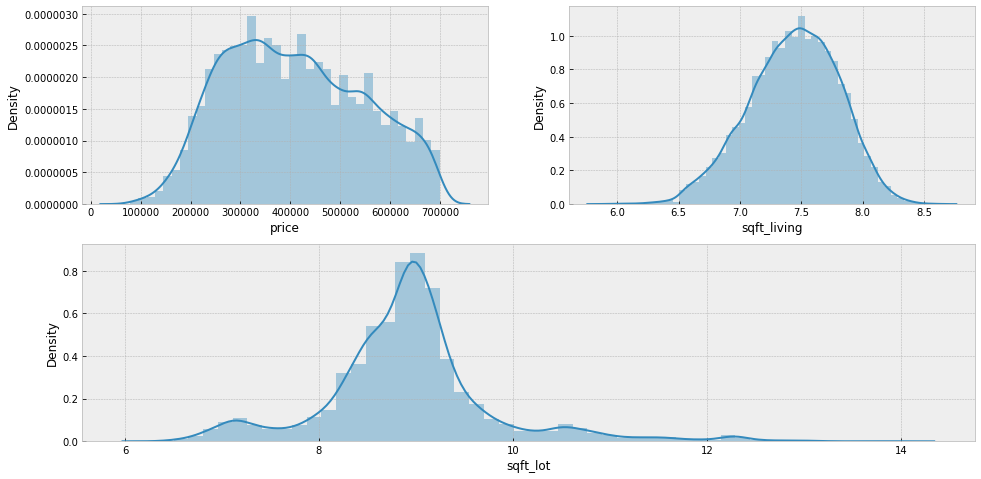

In [27]:
#Preview new distributions after min-max scaling
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.distplot(df.price, label='Prices')
plt.subplot(222)
sns.distplot(df.sqft_living, label='Sqft Living')
plt.subplot(212)
sns.distplot(df.sqft_lot, label='Sqft Lot')

In [28]:
model2 = create_ols(df,target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     883.4
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:13:34   Log-Likelihood:            -2.2123e+05
No. Observations:               17021   AIC:                         4.425e+05
Df Residuals:                   17007   BIC:                         4.426e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -8.951e+06   1.73e+06     -5.188      

### Model 3

In [29]:
df['home_age'] = df['yr_built'].apply(lambda x: 2015 - x)

In [32]:
df.drop(columns='yr_built')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,sqft_lot15,renovated,home_age
0,221900.0,3,1.00,7.073270,8.639411,1.0,0.0,0.0,3,7,98178,5650,0,60
1,538000.0,3,2.25,7.851661,8.887653,2.0,0.0,0.0,3,7,98125,7639,0,64
2,180000.0,2,1.00,6.646391,9.210340,1.0,0.0,0.0,3,6,98028,8062,0,82
3,604000.0,4,3.00,7.580700,8.517193,1.0,0.0,0.0,5,7,98136,5000,0,50
4,510000.0,3,2.00,7.426549,8.997147,1.0,0.0,0.0,3,8,98074,7503,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,7.333023,7.030857,3.0,0.0,0.0,3,8,98103,1509,0,6
21593,400000.0,4,2.50,7.745003,8.667852,2.0,0.0,0.0,3,8,98146,7200,0,1
21594,402101.0,2,0.75,6.927558,7.207860,2.0,0.0,0.0,3,7,98144,2007,0,6
21595,400000.0,3,2.50,7.377759,7.778211,2.0,0.0,0.0,3,8,98027,1287,0,11


In [33]:
df.waterfront = df.waterfront.astype('category')
df.view = df.view.astype('category')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')
df.zipcode = df.zipcode.astype('category')
df.bedrooms = df.bedrooms.astype('category')
df.floors = df.floors.astype('category')
df.bathrooms = df.bathrooms.astype('int').astype('category')

In [34]:
#Making Dummies
waterfront = pd.get_dummies(df.waterfront, prefix='waterfront', drop_first=True)
view = pd.get_dummies(df.view, prefix='view', drop_first=True)
condition = pd.get_dummies(df.condition, prefix='condition', drop_first=True)
grade = pd.get_dummies(df.grade, prefix='grade', drop_first=True)
zipcode = pd.get_dummies(df.zipcode, prefix='zipcode', drop_first=True)
bedrooms = pd.get_dummies(df.bedrooms, prefix='bedrooms', drop_first=True)
floors = pd.get_dummies(df.floors, prefix='floors', drop_first=True)
bathrooms = pd.get_dummies(df.bathrooms, prefix='bathrooms', drop_first=True)

In [35]:
df = df.join([waterfront, view, condition, grade, zipcode, bedrooms, floors,  bathrooms])
df.drop(['waterfront','view','condition','grade','zipcode','bedrooms', 'floors', 'bathrooms'], axis=1, inplace=True)

In [39]:
subs = [('.','')]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df.columns = [col_formatting(col) for col in df.columns]

In [41]:
model3 = create_ols(df,target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     567.8
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:23:13   Log-Likelihood:            -2.1252e+05
No. Observations:               17021   AIC:                         4.253e+05
Df Residuals:                   16911   BIC:                         4.261e+05
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4536      0.037    -12.196